[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jonarod/Bootcamp-Inteligencia-Artificial-Women-Who-Code-Medellin/blob/master/semana%204/CNN%20deteccion/Pyramiding%20and%20sliding%20windows/Pyramiding_and_sliding_windows.ipynb)

In [1]:
import cv2
import imutils
import numpy as np
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_resnet_v2 import *
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
class ObjectDetector(object):
    def __init__(self, classifier,
                 preprocess_fn=lambda x: x,
                 input_size=(299, 299),
                 confidence=0.98,
                 window_step_size=16,
                 pyramid_scale=1.5,
                 roi_size=(200, 150),
                 nms_threshold=0.3):
        
        self.classifier = classifier
        self.preprocess_fn = preprocess_fn
        self.input_size = input_size
        self.confidence = confidence

        self.window_step_size = window_step_size

        self.pyramid_scale = pyramid_scale
        self.roi_size = roi_size
        self.nms_threshold = nms_threshold

    def sliding_window(self, image):
        for y in range(0, image.shape[0], self.window_step_size):
            for x in range(0, image.shape[1], self.window_step_size):
                y_slice = slice(y, y + self.roi_size[1], 1)
                x_slice = slice(x, x + self.roi_size[0], 1)

                yield x, y, image[y_slice, x_slice]

    def pyramid(self, image):
        yield image

        while True:
            width = int(image.shape[1] / self.pyramid_scale)
            image = imutils.resize(image, width=width)

            if (image.shape[0] < self.roi_size[1] or image.shape[1] < self.roi_size[0]):
                break

            yield image

    def non_max_suppression(self, boxes, probabilities):
        if len(boxes) == 0:
            return []

        if boxes.dtype.kind == 'i':
            boxes = boxes.astype(np.float)

        pick = []

        x_1 = boxes[:, 0]
        y_1 = boxes[:, 1]
        x_2 = boxes[:, 2]
        y_2 = boxes[:, 3]

        area = (x_2 - x_1 + 1) * (y_2 - y_1 + 1)
        indexes = np.argsort(probabilities)

        while len(indexes) > 0:
            last = len(indexes) - 1
            i = indexes[last]
            pick.append(i)

            xx_1 = np.maximum(x_1[i], x_1[indexes[:last]])
            yy_1 = np.maximum(y_1[i], y_1[indexes[:last]])
            xx_2 = np.maximum(x_2[i], x_2[indexes[:last]])
            yy_2 = np.maximum(y_2[i], y_2[indexes[:last]])

            width = np.maximum(0, xx_2 - xx_1 + 1)
            height = np.maximum(0, yy_2 - yy_1 + 1)

            overlap = (width * height) / area[indexes[:last]]

            redundant_boxes = np.where(overlap > self.nms_threshold)[0]
            to_delete = np.concatenate(([last], redundant_boxes))
            indexes = np.delete(indexes, to_delete)

        return boxes[pick].astype(np.int)

    def detect(self, image):
        rois = []
        locations = []

        for img in self.pyramid(image):
            scale = image.shape[1] / float(img.shape[1])

            for x, y, roi_original in self.sliding_window(img):
                x = int(x * scale)
                y = int(y * scale)
                w = int(self.roi_size[0] * scale)
                h = int(self.roi_size[1] * scale)

                roi = cv2.resize(roi_original, self.input_size)
                roi = img_to_array(roi)
                roi = self.preprocess_fn(roi)

                rois.append(roi)
                locations.append((x, y, x + w, y + h))

        rois = np.array(rois, dtype=np.float32)

        predictions = self.classifier.predict(rois)
        predictions = imagenet_utils.decode_predictions(predictions, top=1)

        labels = {}
        for i, pred in enumerate(predictions):
            _, label, proba = pred[0]

            if proba >= self.confidence:
                box = locations[i]

                label_detections = labels.get(label, [])
                label_detections.append({'box': box, 'proba': proba})
                labels[label] = label_detections

        return labels


In [3]:
model = InceptionResNetV2(weights='imagenet', include_top=True)

model.summary()

225222656/225209952 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)  

In [4]:
# Importamos una imagen con clase contenida en imagenet (perro, gato etc...)
from google.colab import files
files.upload()

Saving dog.jpeg to dog.jpeg


{'dog.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x03U\x02\x80\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x02\x03\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x06\x07\x04\x05\x08\x02\x03\t\x01\n\x00\x0b\xff\xc4\x00<\x10\x00\x03\x01\x00\x01\x04\x01\x04\x01\x04\x01\x04\x01\x02\x01\r\x01\x02\x03\x04\x05\x06\x11\x12\x13\x14\x00\x07!"#\x08\x1512$\t\x163AB%Q\x174CRa\nDbq5\x81

In [5]:
!ls dog.jpeg

dog.jpeg


In [6]:
object_detector = ObjectDetector(model, preprocess_input)

In [7]:
image = cv2.imread('dog.jpeg')
image = imutils.resize(image, width=600)
labels = object_detector.detect(image)

GREEN = (0, 255, 0)

49152/35363 [=========================================] - 0s 0us/step


In [8]:
for i, label in enumerate(labels.keys()):
    clone = image.copy()

    for detection in labels[label]:
        box = detection['box']
        probability = detection['proba']

        x_start, y_start, x_end, y_end = box
        cv2.rectangle(clone, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

    cv2.imwrite(f'Before_{i}.jpg', clone)

    clone = image.copy()
    boxes = np.array([d['box'] for d in labels[label]])
    probas = np.array([d['proba'] for d in labels[label]])
    boxes = object_detector.non_max_suppression(boxes, probas)

    for x_start, y_start, x_end, y_end in boxes:
        cv2.rectangle(clone, (x_start, y_start), (x_end, y_end), GREEN, 2)

        if y_start - 10 > 10:
            y = y_start - 10
        else:
            y = y_start + 10

        cv2.putText(clone, label, (x_start, y), cv2.FONT_HERSHEY_SIMPLEX, .45, GREEN, 2)

    cv2.imwrite(f'After_{i}.jpg', clone)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


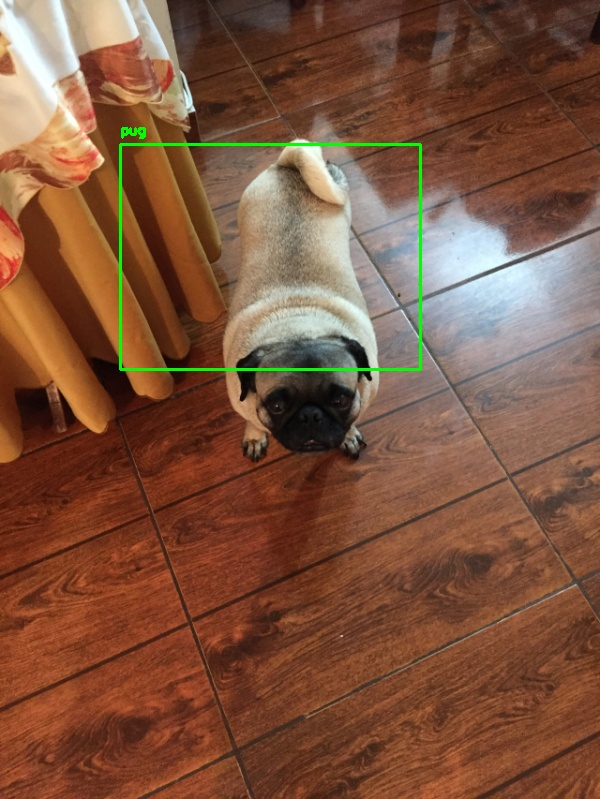

In [9]:
from google.colab.patches import cv2_imshow
img = cv2.imread('After_0.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)